# Abordagem Inicial 

## Objetivo 

### Propor método para:
* encontrar representações comuns de diferentes modalidades sensoriais
* aumentar a quantidade de dados utilizados para redução de dimensionalidade do sinal
* melhorar a sensibilidade de análises MVPA posteriores 

### Inicialmente codificar cada instante de tempo (sem usar janelas no tempo)
### Decodificar o momento que estava na mesma e na outra modalidade a partir do estado reduzido
* Comparar com decodificação usando: (1) Sinais originais, (2) PCA geral, (3) PCA em cada ponto, (4) Auto-encoder
### Ver sobre use da auto-encoders e VAEs
### Checar sobre predição da reprodução do intervalo temporal


In [1]:
import pandas as pd

In [2]:
PATH_FOLDER = '../data/processed/' 

In [3]:
aud_1 =  pd.read_csv(PATH_FOLDER+'auditory_exposure_1.csv')
aud_2 =  pd.read_csv(PATH_FOLDER+'auditory_exposure_2.csv') 
vis_1 =  pd.read_csv(PATH_FOLDER+'visual_exposure_1.csv') 
vis_2 =  pd.read_csv(PATH_FOLDER+'visual_exposure_2.csv')

### Passo 1: treinar com dados completos capturados do experimento
* Entrada e saída como o mesmo sinal (um número para cada eletrodo)
* Usar uma rede fully connected e auto-encoder padrão
    * 64(E) - 32 - 16 - 32 - 64(S)
    * Fazer testes verificando o erro de reconstrução
* Uma rede por voluntário e por modalidade
* Pouca quantidade de dados -> incluir regularização, como dropout, para evitar overfitting


# Por voluntário

In [1]:
import sys

sys.path.append("../src/data/")
sys.path.append("../src/tools/")
sys.path.append("../src/models/")
sys.path.append("../src/external/")
sys.path.append("../src/visualization/")

In [7]:
from variational_auto_enconder import variationalAutoEnconder

In [2]:
from file import *
from conversion import *
from exposure import _exposure_1, _exposure_2, _exposure_1_bad, _exposure_2_bad, get_group_time, fixing_bad_trials, get_last_125ms
from classification import *
from statistical_tests import *
from report import *

1 items had no tests:
    __main__
0 tests in 1 items.
0 passed and 0 failed.
Test passed.


../src/models/classification.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from tqdm.autonotebook import tqdm
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut


In [4]:
from sklearn.model_selection import LeaveOneOut
from tqdm.autonotebook import tqdm
from numpy import average, subtract
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from pandas import DataFrame, concat

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score,precision_score, f1_score, roc_auc_score, make_scorer, recall_score 


In [5]:
def methods_classification(n_neighbors=3,
                           kernel_a='linear', kernel_b='rbf', gamma='auto',
                           max_depth=5,
                           n_estimators=10, random_state=42, max_features=1):
    """

    Parameters
    ----------
    n_neighbors
    kernel_a
    kernel_b
    gamma
    max_depth
    n_estimators
    random_state
    max_features
    max_iter
    """
    # K-NN
    from sklearn.neighbors import KNeighborsClassifier
    # SVM (linear and radial)
    from sklearn import svm
    # Decision tree
    from sklearn.tree import DecisionTreeClassifier
    # random forests
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    # MLPClassifier
    from sklearn.neural_network import MLPClassifier
    # AdaBoostClassifier
    from sklearn.ensemble import AdaBoostClassifier
    # GaussianNB
    from sklearn.naive_bayes import GaussianNB

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)  # 1
    SVM1 = svm.SVC(kernel=kernel_a)  # 2
    SVM2 = svm.SVC(kernel=kernel_b, gamma=gamma)  # 3
    DT = DecisionTreeClassifier(max_depth=max_depth)  # 4
    RF = RandomForestClassifier(
        n_estimators=n_estimators, random_state=random_state, max_features=max_features)  # 5
    MLP = MLPClassifier()  # 6
    ADB = AdaBoostClassifier(random_state=random_state)  # 7
    #from sklearn.naive_bayes import GaussianNB
    GaussianNB_ = GaussianNB()  # 8
    
    GaussianNB_.class_prior_ = [(1/6),(1/6),(1/6),(1/6),(1/6),(1/6)]

    ensemble = VotingClassifier(estimators=[('k-NN', knn), ('SVM1', SVM1), ('SVM2', SVM2),
                                            ('DT', DT), ('RF', RF), ('MLP', MLP), 
                                            ('ADB', ADB),
                                            ('GNB', GaussianNB_)], voting='hard')

    classifiers = [('k-NN', knn), ('SVM1', SVM1), ('SVM2', SVM2), ('DT', DT), ('RF', RF),
                   ('MLP', MLP), ('ADB', ADB), ('GNB', GaussianNB_),
                   ("Ensemble", ensemble)]

    return classifiers



In [6]:
def fit_method(classifiers, X_train, Y_train):
    """
    REALLY unoptimized function to save the metrics.

    """
    
    for classifier_name, classifier in classifiers:
        classifier.fit(X_train, Y_train)


    return classifiers

def predict_method(classifiers, X_test, Y_test):
    """
    REALLY unoptimized function to save the metrics.

    """
    metrics = []
    for classifier_name, classifier in classifiers:
        Y_pred = classifier.predict(X_test)
        
        acc = accuracy_score(Y_test ,Y_pred)
        pre = precision_score(Y_test ,Y_pred, average='weighted')
        rec = recall_score(Y_test ,Y_pred, average='weighted')
        f1  = f1_score(Y_test ,Y_pred, average='weighted')
        #roc = roc_auc_score(Y_test ,Y_pred, average='weighted', multi_class='ovr')
        
        metrics.append([acc,pre,rec,f1])

    return metrics

In [33]:
def classification_autoEncoder(dataFrame, categoria, exposure):
    '''






    '''


    dataFrame_result = []
    history = []

    for ind, pearson in tqdm(dataFrame.groupby('people')):

        X = pearson.drop(['trial', 'group', 'people'], 1)
        y = pearson['group']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        

        train_mean = np.average(X_train, axis=0)

        X_train_without_mean = np.subtract(X_train, train_mean)
        X_test_without_mean = np.subtract(X_test, train_mean)

        X_train_without_mean = X_train_without_mean.T
        X_test_without_mean = X_test_without_mean.T
        
        
        autoEncoder_ = AutoEnconder(epochs=1000,
                                       batch_size=32,
                                       validation_size=[],
                                       random_state=42,
                                       regularizer=regularizers.l1(10e-5),
                                       exposure=exposure,
                                       modality=categoria)

        autoEncoder_.make_auto_enconder(16)

        autoEncoder_.fit(X_train_without_mean)
        
        
        history.append(autoEncoder_.history)
        
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
        X_train_auto = autoEncoder_.transform(X_train_without_mean.T)

        X_test_auto = autoEncoder_.transform(X_test_without_mean.T)

       
        clf = methods_classification()
        #import pdb; pdb.set_trace()
        
        clf = fit_method(clf, X_train, y_train)
        
        historico = predict_method(clf, X_test, y_test)
        
        dataFrame_result.append([ind, historico, categoria, exposure])

            
    return dataFrame_result, history

In [43]:
def classification_autoEncoder(dataFrame, categoria, exposure):
    '''






    '''

    dataFrame_result = []
    history = []

    for ind, pearson in tqdm(dataFrame.groupby('people')):

        X = dataFrame.drop(['trial', 'group', 'people'], 1)
        y = dataFrame['group']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        
        train_mean = np.average(X_train, axis=0)

        X_train_without_mean = np.subtract(X_train, train_mean)
        X_test_without_mean = np.subtract(X_test, train_mean)

        X_train_without_mean = X_train_without_mean.T
        X_test_without_mean = X_test_without_mean.T

        clf = GaussianNB()

        
        clf.class_prior_ = [(1/6),(1/6),(1/6),(1/6),(1/6),(1/6)]
        
        autoEncoder_ = AutoEnconder(epochs=100,
                                       batch_size=32,
                                       validation_size=[],
                                       random_state=42,
                                       regularizer=regularizers.l1(10e-5),
                                       exposure=exposure,
                                       modality=categoria)

        autoEncoder_.make_auto_enconder(16)

        autoEncoder_.fit(X_train_without_mean)
        
        history.append(autoEncoder_.history)
        
        X_train_auto = autoEncoder_.transform(X_train_without_mean.T)

        X_test_auto = autoEncoder_.transform(X_test_without_mean.T)


        clf = clf.fit(X_train_auto, y_train)

        y_pred = clf.predict(X_test_auto)

        for y_i_pred, y_i_test in list(zip(y_pred,y_test.values)):
            dataFrame_result.append([ind, y_i_pred,y_i_test, categoria, exposure])

            
    return dataFrame_result, autoEncoder_.history

In [42]:
def train_transform_autoEncoder(dataFrame, categoria, exposure):
    '''






    '''

    X = dataFrame.drop(['trial', 'group', 'people'], 1)
    y = dataFrame['group']

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, random_state=42)

    train_mean = np.average(X_train, axis=0)

    X_train_without_mean = np.subtract(X_train, train_mean)
    X_test_without_mean = np.subtract(X_test, train_mean)

    X_train_without_mean = X_train_without_mean.T
    X_test_without_mean = X_test_without_mean.T

    autoEncoder_ = AutoEnconder(epochs=100,
                                   batch_size=32,
                                   validation_size=[],
                                   random_state=42,
                                   regularizer=regularizers.l1(10e-5),
                                   exposure=exposure,
                                   modality=categoria)

    autoEncoder_.make_auto_enconder(8)

    autoEncoder_.fit(X_train_without_mean)

    X_train_auto = autoEncoder_.transform(X_train_without_mean.T)

    X_test_auto = autoEncoder_.transform(X_test_without_mean.T)

            
    return X_train_auto, X_test_auto, y_train, y_tes, autoEncoder_

In [36]:
resu_aud_1, history_aud_1 = classification_autoEncoder(aud_1,'Auditory','E1')


AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [10]:
N_PEOPLE = 20
PATH_AUD = '../data/raw/aud'
PATH_VIS = '../data/raw/vis'
PATH_INFO = '../data/raw/info_'

N_CHANNELS = 64
#N_CHANNELS = 62

ORIGINAL_FREQUENCY = 1000

DOWN_SAMPLED_FREQUENCY = 250

In [11]:
data_aud, data_vis, CHANNEL_NAMES = read_file(PATH_AUD, PATH_VIS)

In [12]:
## Splitting the exposures for all the individuals

aud_1 = _exposure_1(data_aud)

aud_2 = _exposure_2(data_aud) 

vis_1 = _exposure_1(data_vis)

vis_2 = _exposure_2(data_vis)

In [14]:
bad_trials_aud, bad_trials_vis = get_bad_trials(PATH_AUD, PATH_VIS)

In [15]:
## Splitting the exposures for all the individuals

bad_aud_1 = _exposure_1_bad(bad_trials_aud, 'Aud')

bad_aud_2 = _exposure_2_bad(bad_trials_aud, 'Aud') 

bad_vis_1 = _exposure_1_bad(bad_trials_vis, 'Vis')

bad_vis_2 = _exposure_2_bad(bad_trials_vis, 'Vis')

In [16]:
bad_vis_comport = get_bad_trials_comportamental('vis')
bad_aud_comport = get_bad_trials_comportamental('aud')

In [20]:
indice_s2_vis = get_time_delay('vis')
indice_s2_aud = get_time_delay('aud')

time_s2_vis = get_time_delay('vis', export_as_indice=False)
time_s2_aud = get_time_delay('aud', export_as_indice=False)

In [22]:
clean_aud_1, clean_aud_2, clean_vis_1, clean_vis_2 = fixing_bad_trials(
    bad_aud_1, bad_aud_2, bad_vis_1, bad_vis_2)

In [21]:
clean_aud_1 = clean_aud_1.append(bad_aud_comport,ignore_index=True)
clean_aud_2 = clean_aud_2.append(bad_aud_comport,ignore_index=True)

clean_vis_1 = clean_vis_1.append(bad_vis_comport,ignore_index=True)
clean_vis_2 = clean_vis_2.append(bad_vis_comport,ignore_index=True)

In [23]:
indice_s2_vis = get_time_delay('vis')
indice_s2_aud = get_time_delay('aud')

time_s2_vis = get_time_delay('vis', export_as_indice=False)
time_s2_aud = get_time_delay('aud', export_as_indice=False)

In [24]:
aud_1_average = list(map(get_last_125ms, aud_1, indice_s2_aud))
aud_2_average = list(map(get_last_125ms, aud_2, indice_s2_aud))


vis_1_average = list(map(get_last_125ms, vis_1, indice_s2_vis))
vis_2_average = list(map(get_last_125ms, vis_2, indice_s2_vis))

In [25]:
classes_aud, classes_vis = get_group_time(time_s2_aud, time_s2_vis)

In [26]:
#Getting in format of dataframe:

df_aud_1_aver = to_DataFrame(aud_1_average,classes_aud,CHANNEL_NAMES)
df_aud_2_aver = to_DataFrame(aud_2_average,classes_aud,CHANNEL_NAMES)

df_vis_1_aver = to_DataFrame(vis_1_average,classes_vis,CHANNEL_NAMES)
df_vis_2_aver = to_DataFrame(vis_2_average,classes_vis,CHANNEL_NAMES)

In [28]:
from sklearn.model_selection import train_test_split


In [38]:
from my_autoenconder import AutoEnconder

In [46]:
dataFrame_result, history  = classification_autoEncoder(df_aud_1_aver,'Auditory','E1')

KeyboardInterrupt: 

In [47]:
resu_aud_2, history_aud_2 = classification_autoEncoder(df_aud_2_aver,'Auditory','E2')

resu_aud_1, history_aud_1 = classification_autoEncoder(df_aud_1_aver,'Auditory','E1')


resu_vis_2, history_vis_2 = classification_autoEncoder(df_vis_2_aver,'Auditory','E2')

resu_vis_1, history_vis_1 = classification_autoEncoder(df_vis_1_aver,'Auditory','E1')




In [48]:
import matplotlib.pyplot as plt

    
def plot_history(history):

    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
resu_vis_1, history_vis_1 = classification_autoEncoder(vis_1,'Visual','E1')


In [ ]:
resu_vis_2, history_vis_2 = classification_autoEncoder(vis_2,'Visual','E2')


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


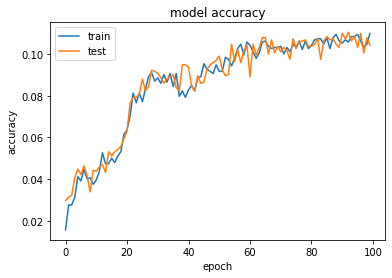

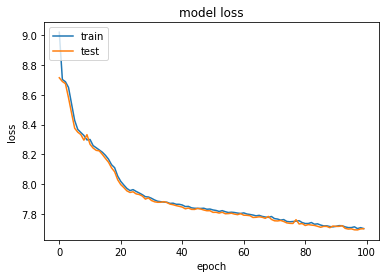

In [59]:
plot_history(history_aud_1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


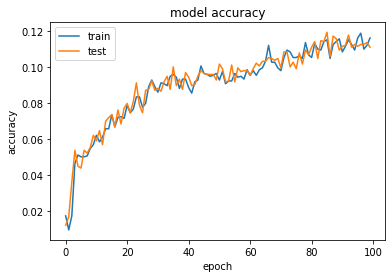

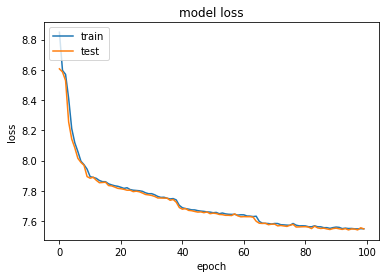

In [60]:
plot_history(history_aud_2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


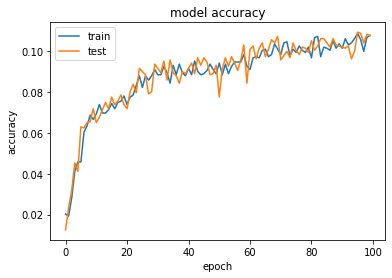

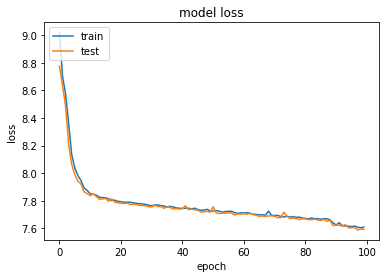

In [61]:
plot_history(history_vis_1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


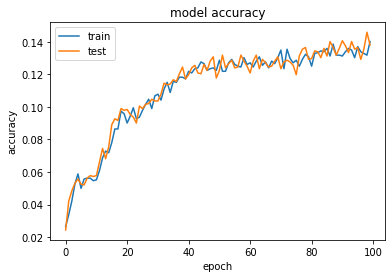

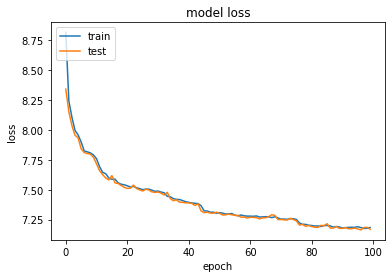

In [62]:
plot_history(history_vis_2)

In [49]:
merge_autoenco, merge_autoenco_mode = merge_export(resu_aud_1, resu_aud_2,
                                                   resu_vis_1, resu_vis_2,
                                                   '../data/processed/auto_enconder_1.csv')

In [50]:
ck_auto = cohen_kappa(merge_autoenco, plot_option=False, title='')

In [52]:
plot_

,id_person,Exposures,Modality,Cohen_Kappa
0,0,E1,Auditory,0.022390
1,0,E2,Auditory,0.031299
2,1,E1,Auditory,-0.019640
3,1,E2,Auditory,0.045174
4,2,E1,Auditory,-0.040664
5,2,E2,Auditory,-0.002010
6,3,E1,Auditory,0.032441
7,3,E2,Auditory,-0.010345
8,4,E1,Auditory,-0.007676
9,4,E2,Auditory,0.062756


In [53]:
print_classification_by_mod(merge_autoenco)

##################################################
Classificação nos Dados Visual, exposição 1


ValueError: max() arg is an empty sequence

In [54]:
t_test(ck_auto)

,,Stats,p-value
Exposures,Modality,,
E1,Auditory,3.895788,0.000972
E2,Auditory,6.364676,0.000004


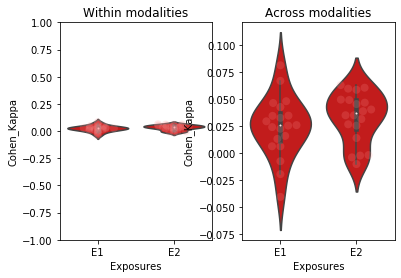

In [58]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(1,2)
    
ax_ck_with = axs[0]
ax_ck_acro = axs[1]


ax_ck_acro = violinplot(x="Exposures", y="Cohen_Kappa", hue="Modality",
                        data=ck_auto, palette=['#de0000', '#001a8d'], ax=ax_ck_acro)
ax_ck_acro = swarmplot(x="Exposures", y="Cohen_Kappa", hue="Modality",
                       data=ck_auto, size=8, ax=ax_ck_acro,
                       palette=['#ff9293', '#aaaaff'],
                       dodge=True,
                       alpha=.2)

ax_ck_acro.set_title('Across modalities')
ax_ck_acro.get_legend().remove()

ax_ck_with = violinplot(x="Exposures", y="Cohen_Kappa", hue="Modality",
                        data=ck_auto, palette=['#de0000', '#001a8d'], ax=ax_ck_with)
ax_ck_with = swarmplot(x="Exposures", y="Cohen_Kappa", hue="Modality",
                       data=ck_auto, size=8, ax=ax_ck_with,
                       palette=['#ff9293', '#aaaaff'],
                       dodge=True,
                       alpha=.2)

ax_ck_with.set_title('Within modalities')
ax_ck_with.get_legend().remove()
ax_ck_with = ax_ck_with.set(ylim=(-1, 1))



In [ ]:
plot_history

### Passo 2: gerar uma representação comum entre ambas as modalidades
* Treinar com a mesma rede para visual e auditivo
* Objetivo é verificar se gera uma melhor representação comum entre as modalidades
* Comparar o desempenho com a rede treinada em apenas uma modalidade
* Treinar redes separadas para visual e auditivo, compartilhando a parte da codificação
* Treinamento com exemplos de ambas as modalidades
* Pode ser mais interessante, pois enfatiza uma codificação comum, mas permite diferenciações na decodificação




### Passo 3: obter representações comuns entre sujeitos
* Treinar a mesma rede para todos os participantes 
* Objetivo é gerar as codificações a partir de grandes quantidades de dados
* Abordagem 1: Fazer para a rede uma rede codificação/decodificação comum a todos
    * Depois pode ser afinada para cada participante individualmente
* Abordagem 2: Usar apenas a parte de codificação em comum
    * Enfatiza uma codificação comum, mas permite diferenciações na decodificação
* Neste caso o classificador poderia ser comum também?



### Passo 4: capturar informação temporal (opcional)
* Repetir os passos anteriores, mas usando 5 valores para cada eletrodo (1 a cada 25 ms)
* Objetivo é verificar se mais detalhes temporais melhoram a representação do tempo
* Inicialmente utilizar uma arquitetura fully connected 
    * 320(E) - 160 - 80 - 40 - 80 - 160 - 320(S)
* Outra possibilidade é colocar alguma estrutura
* Transformação é inicialmente realizada sobre a série temporal de cada eletrodo
* Poderia também juntar sinais de eletrodos vizinhos
* Isso permitiria diminuir o número de conexões